#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import shutil
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

#Raw data download

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   165M      0  0:00:04  0:00:04 --:--:--  169M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip  'readme[1].txt'
 drive			   PetImages		        sample_data


In [ ]:
!curl -L -o /content/human-faces.zip https://www.kaggle.com/api/v1/datasets/download/ashwingupta3012/human-faces

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1861M  100 1861M    0     0  22.2M      0  0:01:23  0:01:23 --:--:-- 24.1M


#### Unzip data and show items in folder


In [ ]:
!unzip -q human-faces.zip
!ls

 CDLA-Permissive-2.0.pdf   human-faces.zip   kagglecatsanddogs_5340.zip  'readme[1].txt'
 drive			   Humans	     PetImages			  sample_data


In [ ]:
# Specify the directory name
def create_folder(directory_name):
  # directory_name = "data"

  # Create the directory
  try:
      os.mkdir(directory_name)
      print(f"Directory '{directory_name}' created successfully.")
  except FileExistsError:
      print(f"Directory '{directory_name}' already exists.")
  except PermissionError:
      print(f"Permission denied: Unable to create '{directory_name}'.")
  except Exception as e:
      print(f"An error occurred: {e}")

In [ ]:
create_folder('data')

Directory 'data' created successfully.


#### Manage data

In [ ]:
def move_data(source):
  destination = '/content/data/'
  dest = shutil.move(source, destination)

source = '/content/PetImages/Dog'
move_data(source)

source = '/content/PetImages/Cat'
move_data(source)

os.rmdir('/content/PetImages/')

source = '/content/Humans'
move_data(source)

In [ ]:
!ls data

Cat  Dog  Humans


#Preprocessing

#### Show folders containing images for cats and dogs


#### Remove Corrupted files

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog", "Humans"):
    folder_path = os.path.join("data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


#### Generate datasets train and validation

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 30230 files belonging to 3 classes.
Using 24184 files for training.
Using 6046 files for validation.


#### Visualize data

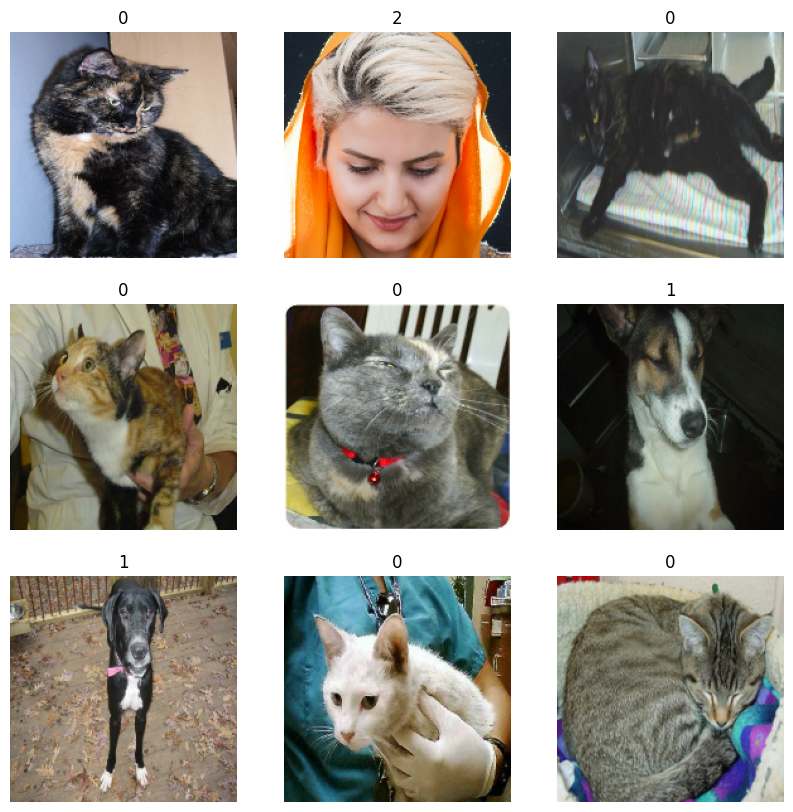

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#### Data augmentation

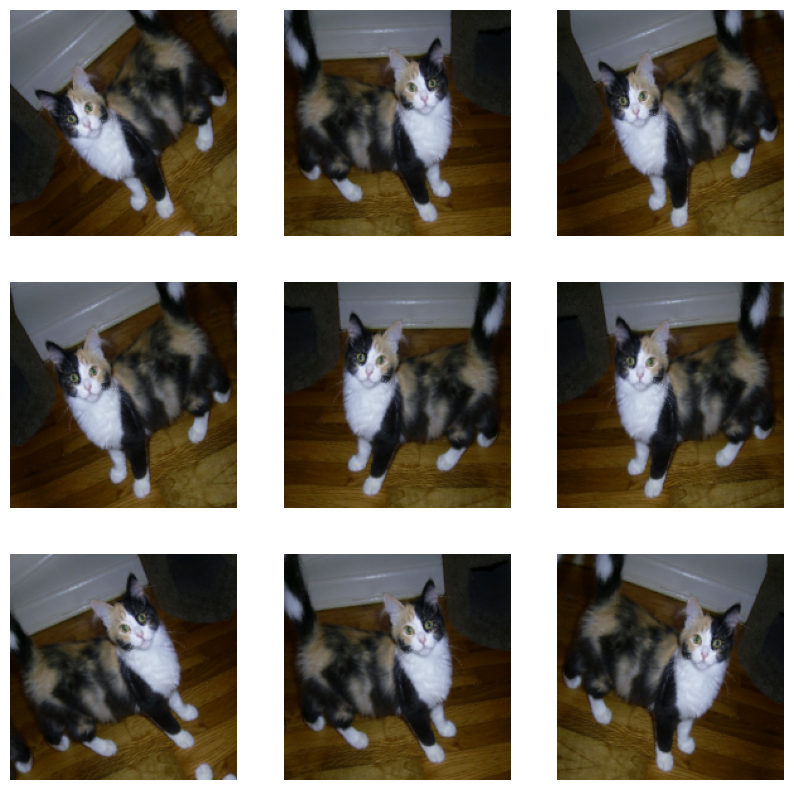

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

### data augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

# Setup the dataset for performance

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

#Xception Model

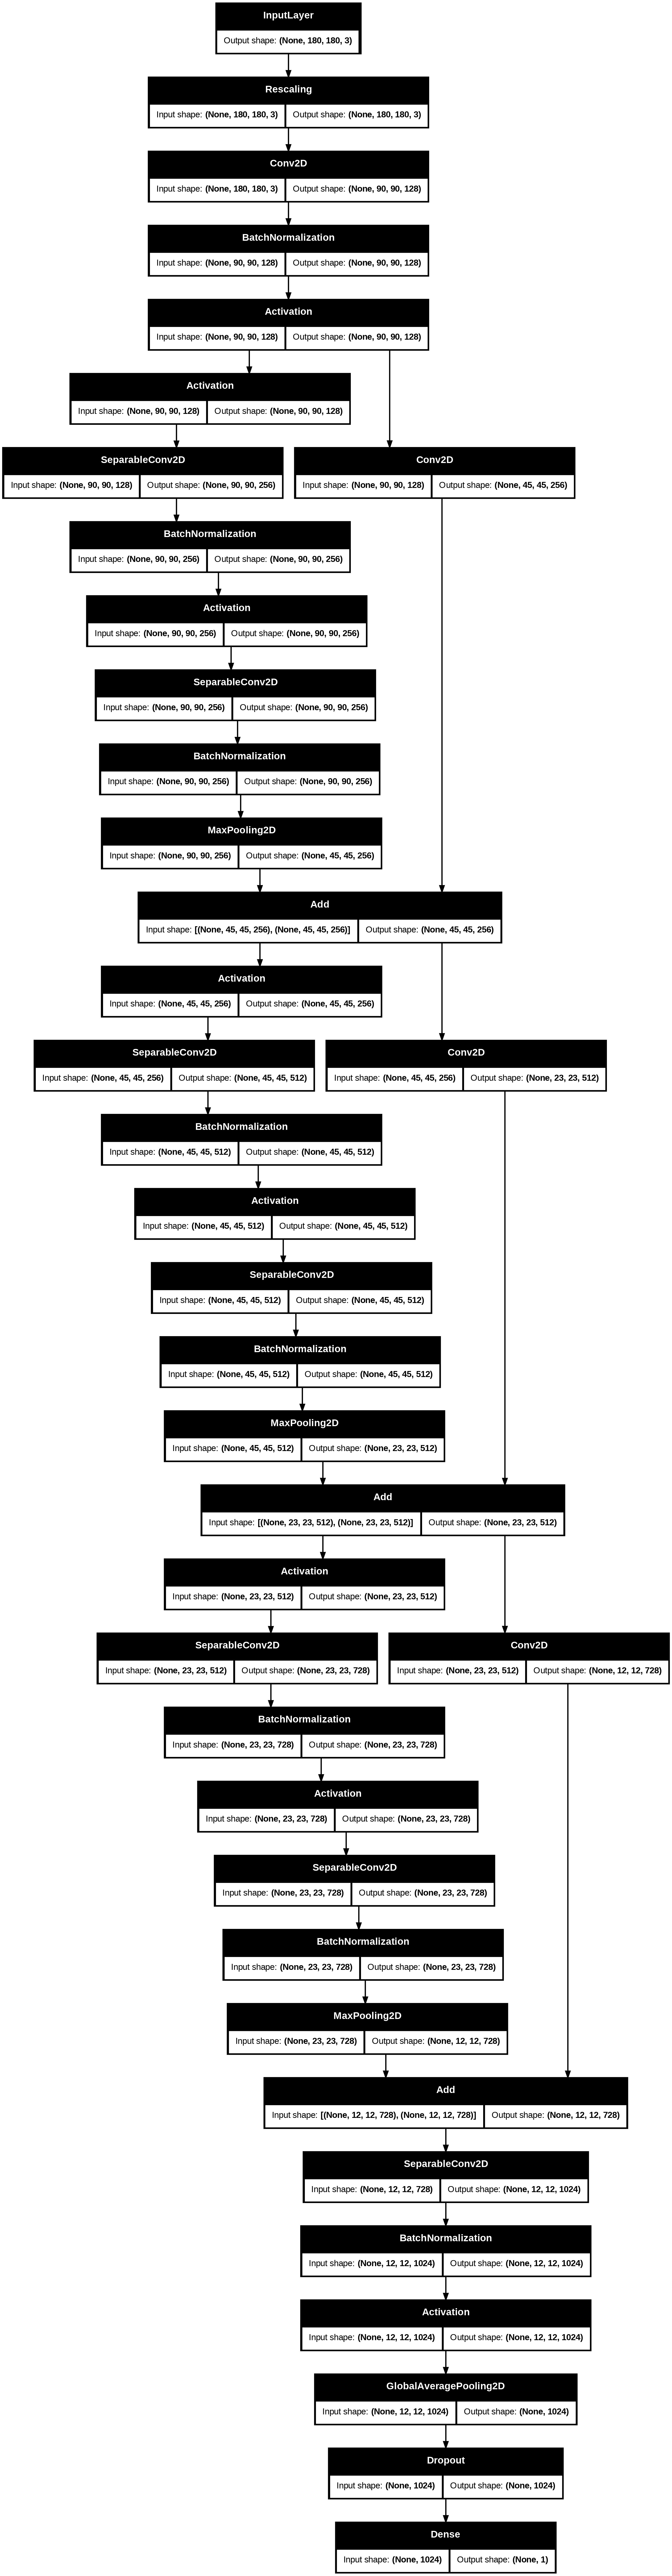

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
create_folder('checkpoints')

### Model train
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/checkpoints/save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Directory 'checkpoints' already exists.
Epoch 1/25


# Finetuning

# Save Model

In [ ]:
create_folder('models')

model.save('my_model.keras')

# reload model for checking
new_model = tf.keras.models.load_model('my_model.keras')

new_model.summary()

In [ ]:
from google.colab import files
files.download('my_model.keras')